In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/ANN2DL_HW2_Shared

/content/drive/MyDrive/ANN2DL_HW2_Shared


In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
x_file_path = "./original_data/x_train.npy"
y_file_path = "./original_data/y_train.npy"

X = np.load(x_file_path)
y = np.load(y_file_path)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1943, 36, 6), (1943,), (486, 36, 6), (486,))

In [8]:
means = []
stds = []
mins = []
maxs = []

X_std_train = X_train
X_norm_train = X_train

for dim in range(X_train.shape[2]):
  data = X_train[:,:,dim]
  mean = np.mean(data)
  std = np.std(data)
  min = np.min(data)
  max = np.max(data)

  data_std = (data - mean)/std
  data_norm = (data - min)/(max-min)

  X_std_train[:,:,dim] = data_std
  X_norm_train[:,:,dim] = data_norm

  means.append(np.mean(data))
  stds.append(np.std(data))
  mins.append(np.min(data))
  maxs.append(np.max(data))

In [9]:
X_std_val = X_val
X_norm_val = X_val

for dim in range(X_val.shape[2]):
  data = X_val[:,:,dim]
  mean = means[dim]
  std = stds[dim]
  min = mins[dim]
  max = maxs[dim]

  data_std = (data - mean)/std
  data_norm = (data - min)/(max-min)

  X_std_val[:,:,dim] = data_std
  X_norm_val[:,:,dim] = data_norm

In [10]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_train.shape, y_val.shape

((1943, 12), (486, 12))

In [22]:
X_train = X_std_train
X_val = X_std_val
print(means)

[0.09433985044511278, 0.20726634307456177, 0.217929972365004, 0.1744093009826522, 0.16060878233497244, 0.1256256820585902]


In [34]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name, experiments_name):

  exps_dir = os.path.join(experiments_name)
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  return callbacks

In [35]:
from tensorflow.keras import backend

class MinimalRNNCell(tfkl.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = backend.dot(inputs, self.kernel)
        output = h + backend.dot(prev_output, self.recurrent_kernel)
        return output, [output]


In [36]:
from tensorflow.python import rnn_cell

cell = MinimalRNNCell(128)

In [37]:
from tensorflow.python import rnn_cell

def build_RNN_classifier(input_shape, classes, model_name, lr=0.001):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    rnn = tfkl.SimpleRNN(256)(input_layer)
    dropout1 = tfkl.Dropout(0.3, seed=seed)(rnn)

    classifier = tfkl.Dense(256, activation='relu')(dropout1)
    dropout2 = tfkl.Dropout(0.3, seed=seed)(classifier)

    output_layer = tfkl.Dense(classes, activation='softmax')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name=model_name)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [38]:
model_name = "RNN"
experiments_name = "no_oversampling_std_normalization"

input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

patience1 = 25
patience_plateau = 5
min_lr = 1e-5
lr_factor = 0.5

In [39]:
model = build_RNN_classifier(input_shape, classes, model_name)
model.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               67328     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                3084      
                                                                 
Total params: 136,204
Trainable params: 136,204
Non-trainable p

In [40]:
%cd ./andrea/RNN

/content/drive/MyDrive/ANN2DL_HW2_Shared/andrea/RNN


In [41]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name, experiments_name)
cbs.append([tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience1, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=patience_plateau, factor=lr_factor, min_lr=min_lr)])


# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = cbs
).history

Epoch 1/200
16/16 [==============================] - 4s 56ms/step - loss: 2.1912 - accuracy: 0.2759 - val_loss: 2.3314 - val_accuracy: 0.2099 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 1s 39ms/step - loss: 2.1499 - accuracy: 0.3057 - val_loss: 2.2944 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 1s 38ms/step - loss: 2.1509 - accuracy: 0.3134 - val_loss: 2.2953 - val_accuracy: 0.2202 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 1s 34ms/step - loss: 2.1334 - accuracy: 0.3129 - val_loss: 2.2940 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 1s 38ms/step - loss: 2.1408 - accuracy: 0.3021 - val_loss: 2.2945 - val_accuracy: 0.2469 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 1s 35ms/step - loss: 2.1196 - accuracy: 0.3212 - val_loss: 2.2955 - val_accuracy: 0.2531 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 1s 39ms/step - lo

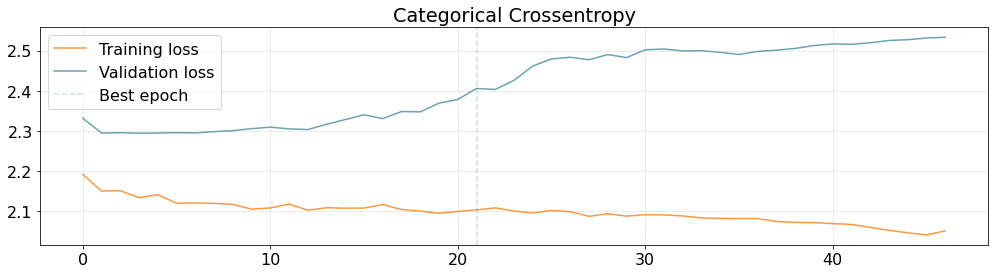

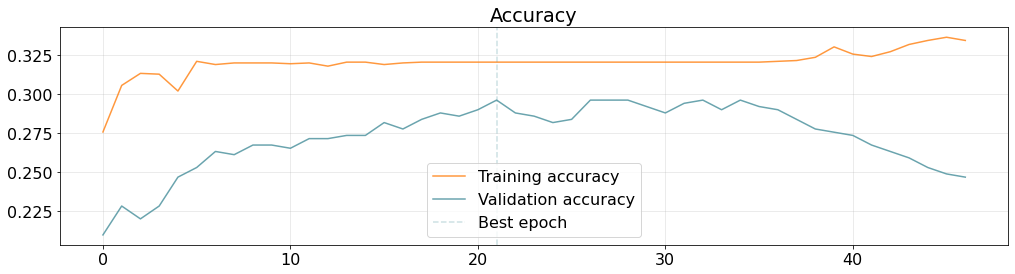

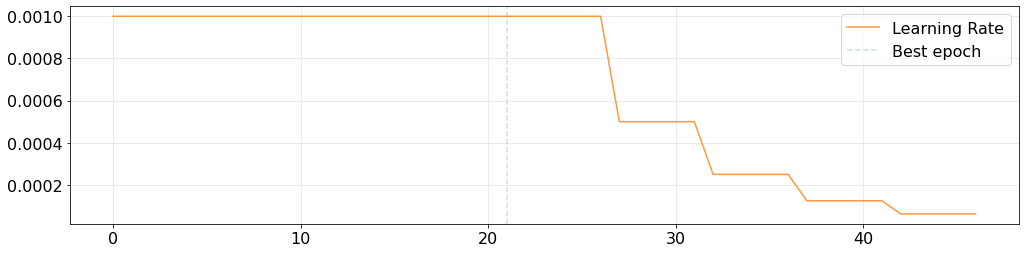

In [42]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [43]:
# Predict the test set with the RNN
predictions = model.predict(X_val)
predictions.shape

16/16 [==============================] - 0s 5ms/step


(486, 12)

Accuracy: 0.2963
Precision: 0.0749
Recall: 0.0879
F1: 0.064


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


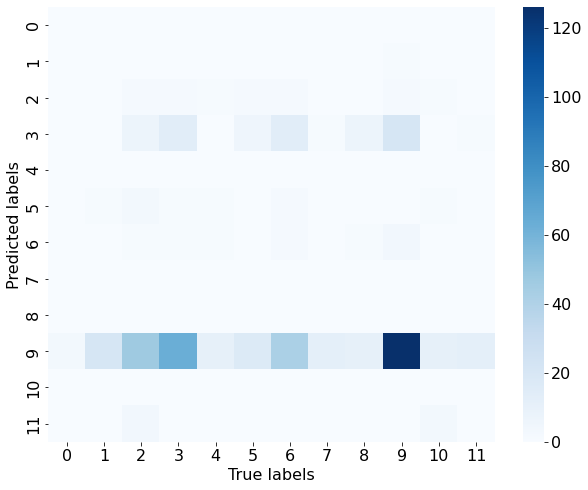

In [44]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=range(classes), yticklabels=range(classes))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [45]:
#model.save(model_name)
# model = tfk.models.load_model(model_name)